#### Identifying bird species infected with H5N1 and finding bird density from past 30 days in Chicago (as of 7/15/2025).   
By: Angel Moreno

In [1]:
import pandas as pd
import geopandas as gpd
import os
import requests
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from datetime import datetime, timedelta
import numpy as np
from shapely.geometry import box
from dotenv import load_dotenv
import libpysal
from esda import getisord
from shapely import Point
import zipfile
import warnings

#### Bird species infected with H5N1 in Midwestern states of interest:

In [3]:
df = pd.read_csv("HPAI Detections in Wild Birds.csv")

mw_states_of_interest = ["Illinois", "Wisconsin", "Michigan"]
dead_birds = df[(df["HPAI Strain"].str.contains("H5N1")) & (df["State"].isin(mw_states_of_interest)) & (df["Sampling Method"]=="Morbidity/Mortality")]
dead_birds["Bird Species"].unique()

array(['Bald eagle', 'Peregrine falcon', 'Sandhill crane',
       'Red-tailed hawk', 'Herring gull', 'Red-breasted merganser',
       'Great horned owl', 'Hawk (unidentified)', 'American crow',
       'Canada goose', 'Trumpeter swan', 'Bufflehead', 'Snowy owl',
       'Tundra swan', 'Chilean flamingo', 'Barred owl', 'Mallard',
       'Hooded merganser', 'Common loon', 'European starling',
       'Snow goose', 'Canvasback', 'Crow (unidentified)', "Ross's goose",
       'American white pelican', 'Common tern', 'Swan (unidentified)',
       'Blue-winged teal', 'Goose (unidentified)', 'Great blue heron',
       'Great egret', 'Pelican (unidentified)', 'Ring-billed gull',
       'Caspian tern', 'Double-crested cormorant', 'Wood duck',
       'Redhead duck', 'Red-winged blackbird', 'Gadwall',
       'Turkey vulture', 'Common raven', 'Ruddy duck',
       'Eagle (unidentified)', 'Rough-legged hawk', 'Red-shouldered hawk',
       "Cooper's hawk", 'Wood Duck', 'Mute swan',
       'Cormorant (uni

In [4]:
# Illinois only
dead_birds_il = df[(df["HPAI Strain"].str.contains("H5N1")) & (df["State"] == "Illinois") & (df["Sampling Method"]=="Morbidity/Mortality")]
dead_birds_il["Bird Species"].unique()

array(['Chilean flamingo', 'Red-breasted merganser', 'Bufflehead',
       'Canada goose', 'Mallard', 'Hooded merganser', 'Sandhill crane',
       'Snow goose', 'Crow (unidentified)', 'Bald eagle',
       'Red-tailed hawk', 'Great horned owl', "Ross's goose",
       'American white pelican', 'Common tern', 'Goose (unidentified)',
       'Swan (unidentified)', 'Pelican (unidentified)',
       'Double-crested cormorant', 'Turkey vulture',
       'Cormorant (unidentified)'], dtype=object)

#### Chicago Bird Migration 30-Day Data (eBird):

In [52]:
# load_dotenv() 

# api_key = os.getenv("EBIRD_API_KEY")
# headers = {"X-eBirdApiToken": api_key}

# params = {
#     # lat and lng corresponds to downtown chicago
#     # 300 S Federal St, Chicago, IL 60604
#     "lat": 41.864231,
#     "lng": -87.627706,
#     "dist": 30, # this covers O'Hare and covers Blue Island
#     "back": 30, # past 30 days
#     "maxResults": 10000
# }

# response = requests.get(
#     "https://api.ebird.org/v2/data/obs/geo/recent",
#     headers=headers,
#     params=params
# )

In [53]:
def get_30_day_data():
    load_dotenv()

    api_key = os.getenv("EBIRD_API_KEY")
    headers = {"X-eBirdApiToken": api_key}

# Location details for downtown Chicago
    lat = 41.864231
    lng = -87.627706
    dist = 30  # in km

# Date range: June 18 – July 18, 2025
    start_date = datetime(2025, 6, 18)
    end_date = datetime(2025, 7, 18)

    all_data = []

    for i in range((end_date - start_date).days + 1):
        date = start_date + timedelta(days=i)
        url = f"https://api.ebird.org/v2/data/obs/US-IL-031/historic/{date.year}/{date.month:02}/{date.day:02}"

        response = requests.get(url, headers=headers, params={"maxResults": 10000})
    
        if response.status_code == 200:
            day_data = response.json()

        # Optional: filter by lat/lng radius manually
            filtered = [
            obs for obs in day_data
            if abs(obs.get("lat", 0) - lat) <= 0.27 and abs(obs.get("lng", 0) - lng) <= 0.37
        ]
            all_data.extend(filtered)
        else:
            print(f"Failed on {date.strftime('%Y-%m-%d')}: {response.status_code}")

# Convert to DataFrame and save
    df = pd.DataFrame(all_data)
    df.to_csv("ebird_june18_july18_2025.csv", index=False)

    return df

In [54]:
# UNCOMMENT TO GET full 30 DAY DATA CSV

# df = get_30_day_data()

In [55]:
df.shape

(13552, 9)

In [56]:
df.head()

,State,County,Collection Date,Date Detected,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,Florida,Hillsborough,3/20/2025,7/3/2025,EA/AM H5N1,Bald eagle,Wild bird,Morbidity/Mortality,Private (non-government) submission
1,Florida,Hillsborough,3/20/2025,7/3/2025,EA/AM H5N1,Bald eagle,Wild bird,Morbidity/Mortality,Private (non-government) submission
2,Florida,Brevard,11/26/2024,7/3/2025,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,FL FWCC
3,New York,Chautauqua,3/17/2025,7/3/2025,EA H5,Bald eagle,Wild bird,Morbidity/Mortality,NY DEC
4,New York,Erie,3/17/2025,7/3/2025,EA/AM H5N1,Bald eagle,Wild bird,Morbidity/Mortality,NY DEC


In [57]:
obs_30d = df

In [10]:
# date_format = "%Y-%m-%d %H:%M"

# obs_30d["date"] = pd.to_datetime(obs_30d["obsDt"], format='ISO8601')

# # will be used for animation
# unique_dates = np.unique(obs_30d['date'])
# len(unique_dates)

<Axes: >

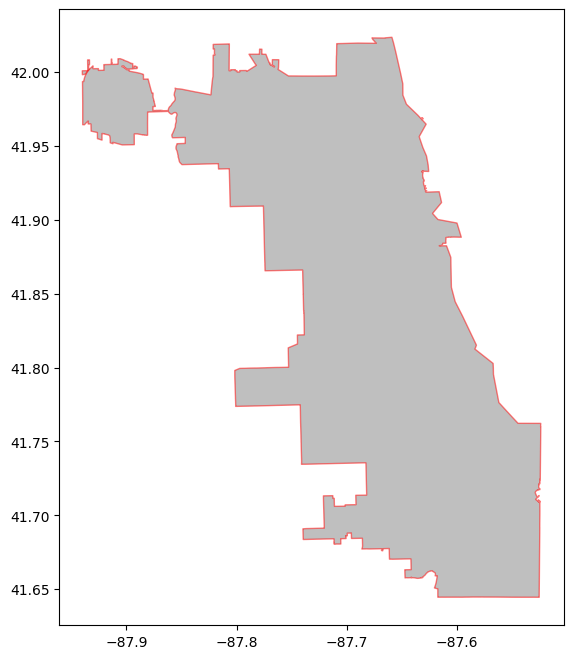

In [2]:
# instead of the tract boundaries -> form into chicago multipolygon
chicago_boundary = gpd.read_file("Chicago_Tracts_2020.zip")
multipolygon = chicago_boundary.dissolve(by=None)
fig, ax = plt.subplots(figsize=(8, 8))
multipolygon.plot(ax=ax, color='grey', edgecolor='red', alpha=0.5)

#### Getis-Ord Gi* Heatmaps:

In [ ]:
type(obs_30d)

In [ ]:
projected = gpd.GeoDataFrame(obs_30d, geometry=gpd.points_from_xy(obs_30d.lng, obs_30d.lat), crs="EPSG:4326")
projected = projected.to_crs("EPSG:3857")
projected.crs

In [ ]:
def create_grid(gdf, cell_size):
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    xmin, ymin, xmax, ymax = bounds
    rows = int((ymax - ymin) / cell_size)
    cols = int((xmax - xmin) / cell_size)
    
    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            x1 = xmin + i * cell_size
            y1 = ymin + j * cell_size
            x2 = x1 + cell_size
            y2 = y1 + cell_size
            grid_cells.append(box(x1, y1, x2, y2))
    
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)
    return grid

In [ ]:
cell_size = 500  # in meters, balanced for the # of data i have
grid = create_grid(projected, cell_size)
grid

In [ ]:
joined = gpd.sjoin(projected, grid, predicate="within")
counts = joined.groupby('index_right').size()
grid['count'] = counts
grid['count'] = grid['count'].fillna(0)

In [ ]:
# Spatial weights
w = libpysal.weights.Queen.from_dataframe(grid)
w.transform = 'r'

# Gi* statistic
gi_star = getisord.G_Local(grid['count'], w)

# Add results to grid
grid['GiZ'] = gi_star.Zs  # Z-scores
grid['pval'] = gi_star.p_sim

In [ ]:
multipolygon = multipolygon.to_crs(grid.crs)

In [ ]:
# significant points only filter:
# significant = grid[grid['pval'] < 0.05]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# significant = grid[grid['pval'] < 0.05]

# Plot Gi* heatmap
grid.plot(column='GiZ', cmap='coolwarm', 
          vmin=-3, vmax=3,
          linewidth=0.1, ax=ax, edgecolor='grey', legend=True)

# Overlay Chicago boundary
multipolygon.boundary.plot(ax=ax, color='black')

# Final touches
ax.set_title("Getis-Ord Gi* Z-scores of Bird Density in Chicago (as of July 18, 2025)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

#### Next steps - Compiling 30 .shp files for each day (past 30 days). 

In [2]:
def get_cstm_bird_data(fname, year_start, month_start, day_start, year_end, month_end, day_end):
    """Gets the past 30 daily bird migration data in Chicago and creates an .shp file (WGS84) for each day.  
    Custom ranges are supported by specifying the start and end date values.  
    Ex. generate_30d_shps(2025, 6, 18, 2025, 7, 18) -> June 18, 2025 to July 18, 2025 data.
    
    Note: this uses the eBird Historic Data api."""
    load_dotenv()

    api_key = os.getenv("EBIRD_API_KEY")
    headers = {"X-eBirdApiToken": api_key}

    # Location details for downtown Chicago
    lat = 41.864231
    lng = -87.627706
    dist = 30  # in km

    # custom date range
    start_date = datetime(year_start, month_start, day_start)
    end_date = datetime(year_end, month_end, day_end)

    # create folder to save the .shp files
    folder_name = os.path.join(fname)
    os.makedirs(folder_name, exist_ok=True)

    # filter for chicago only 
    chicago_boundary = gpd.read_file("Chicago_Tracts_2020.zip")
    multipolygon = chicago_boundary.dissolve(by=None)
    multipolygon = multipolygon.to_crs("epsg:4326")

    for i in range((end_date - start_date).days + 1):
        date = start_date + timedelta(days=i)
        url = f"https://api.ebird.org/v2/data/obs/US-IL-031/historic/{date.year}/{date.month:02}/{date.day:02}"

        response = requests.get(url, headers=headers, params={"maxResults": 10000})
        
        if response.status_code == 200:
            day_data = response.json()

        # Optional: filter by lat/lng radius manually
            filtered = [obs for obs in day_data
            if abs(obs.get("lat", 0) - lat) <= 0.27 and abs(obs.get("lng", 0) - lng) <= 0.37]

        # at each iteration save the shp to the folder created. 
        
            # first create geometry col 
            df_filtered = pd.DataFrame(filtered)
            geometry = [Point(xy) for xy in zip(df_filtered['lng'], df_filtered['lat'])]
            gdf = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs="epsg:4326")

            # clip the entries to chicago only
            clipped = gpd.clip(gdf, chicago_boundary)

            path = os.path.join(folder_name, f"{str(date)[0:10]}_bird_data.shp")
            clipped.to_file(path)

            file_base = os.path.splitext(path)[0]
            zip_path = f"{file_base}.zip"

            with zipfile.ZipFile(zip_path, "w") as zipf:
                for ext in [".shp", ".shx", ".dbf", ".prj", ".cpg"]:
                    file_to_zip = f"{file_base}{ext}"
                    if os.path.exists(file_to_zip):
                        zipf.write(file_to_zip, arcname=os.path.basename(file_to_zip))
                        os.remove(file_to_zip) #clean up files

        else:
            print(f"Failed on {date.strftime('%Y-%m-%d')}: {response.status_code}")

<Axes: >

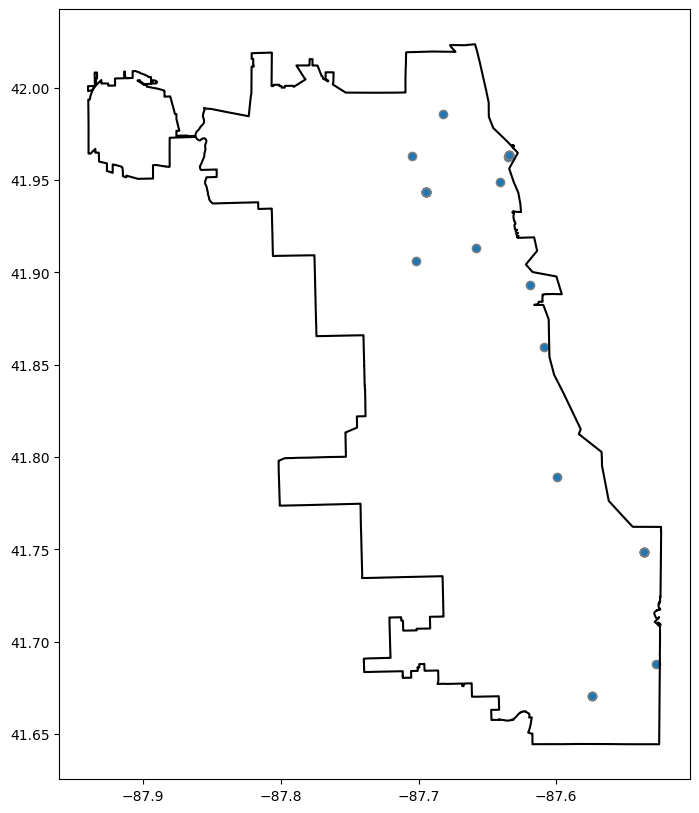

In [ ]:
test = gpd.read_file("30d_bird_chicago/2025-07-15_bird_data.zip")
fig, ax = plt.subplots(figsize=(10, 10))

test.plot(ax=ax, edgecolor='grey', legend=True)

multipolygon.boundary.plot(ax=ax, color='black')

In [4]:
get_cstm_bird_data("six_day_data", 2025, 7, 16, 2025, 7, 21)

C:\Users\ITO\AppData\Local\Temp\ipykernel_8976\377590218.py:54: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped.to_file(path)
c:\Users\ITO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'speciesCode' to 'speciesCod'
  ogr_write(
c:\Users\ITO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'obsReviewed' to 'obsReviewe'
  ogr_write(
c:\Users\ITO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'locationPrivate' to 'locationPr'
  ogr_write(
c:\Users\ITO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'exoticCategory' to 'exoticCate'
  ogr_write(
C:\Users\ITO\AppData\Local\Temp\ipykernel_8976\377590218.py:54: UserWarni